# 功率的时频表示

根据任务的不同，振荡性大脑活动在不同的频带中被调节 (Tallon-Baudry and Bertrand 1999)。为了量化频率特异性调制，每次试验计算功率的时频表示 (TFRs) ，然后取平均值。功率估计使用傅里叶变换和滑动窗口的方法。本节的目的是描述振荡活动的调节对视觉输入的反应。

## Preparation

Import the relevant Python modules:

In [3]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import mne
from mne_bids import BIDSPath, read_raw_bids # If you don't have mne_bids installed, comment this line.

### File overview
The chapter relies on the input file (embedded in the BIDS structure):
~~~
<BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif
~~~

Set the paths for the data and results. Note that these will depend on your local setup.

### Loading the data 

In [4]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '02'  # we have two runs for this subject, let's look at run = 2
meg_suffix = 'meg'
epo_suffix = 'epo'

deriv_root = '/home/ubuntu/database/ds004346-FLUX/derivatives/analysis'

bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-02_epo.fif /home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif


Read the trial-based data stored as epochs:

In [5]:
epochs = mne.read_epochs(bids_path.fpath,
                         proj = False,
                         preload=True,
                         verbose=True)

Reading /home/ubuntu/database/ds004346-FLUX/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-02_epo.fif ...
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
136 matching events found
No baseline correction applied


## 较低频率（<30赫兹）的时频分析
根据经验，我们知道，在较低的频带，如θ、α和β范围内的振荡是相当窄的频带（ΔF~2 Hz），而在γ频带（60-90 Hz）中的神经元活动通常更宽的频带（ΔF~5-10 Hz）。因此，我们建议对较低和较高的频率使用不同的设置。

我们将利用多锥度技术。它被实现为滑动时间窗口方法，其中傅里叶变换用于估计频谱功率。在MNE-Python实现中，傅里叶变换基于卷积类型的方法。对于滑动窗口，数据是“锥形的”，即在傅里叶变换之前的时间窗口中将一个或多个正交锥度乘以数据（Percival和Walden，1993）。这些锥度来自离散的长球体序列（DPSS）。


在分析之前，有3个重要参数要设置。

* *freqs*：定义执行分析的频率范围；在这种情况下，2到30 Hz为1 Hz步长。
* *n_cycles*：以周期为单位定义滑动时间窗口的长度。例如，对于f=10 Hz，周期为T=1/10 Hz=0.1 s长。我们设置n_cycles=freqs/2，ΔT=n_cycles*T，T=1/f，即ΔT=f/2 * 1/f=1/2=0.5s，即对于任何频率，时间窗口为ΔT=500 ms（例如，对于f=10 Hz，变量n_cycles=5导致ΔT=500 ms时间窗口）。
* *time_bandwidth*：（2ΔTΔF）决定了要使用的DPSS锥度的数量。它通常是偶数，锥度的数量是N=time_bandwidth-1。锥度与时间（ΔT）和频谱（ΔF）平滑有关：N<2ΔTΔF（Percival and Walden，1993）。在这个例子中，我们设置time_bandwidth=2.0，即N=1。这导致频谱平滑dF>1 Hz。由于我们只对较低的频率使用一个锥度，实际的频谱平滑是3/2ΔT~3 Hz （没看懂）

要计算所有平面梯度仪的TFR，请分别注意左右条件：

In [4]:
freqs = np.arange(2, 31, 1) # 指定了要计算时频表示的频率范围
n_cycles = freqs / 2 # 每个频率对应的周期数，该参数决定了每个频率成分的时间分辨率。
time_bandwidth = 2.0 # 时间带宽积，这里设置为 2.0。它控制了多锥方法中使用的锥形窗数量，影响时频分辨率的权衡。

tfr_slow_left =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, # 指示使用快速傅里叶变换（FFT）来计算时频表示，这通常比直接时域卷积更快。
    return_itc=False, # 控制是否返回事件间相干性（ITC）。设置为 False 表示只返回功率谱，不返回 ITC
    average=True, # 表示对所有时间段的数据进行平均，最终返回平均的时频表示结果
    decim=2, # 下采样因子，设置为 2 表示在时间维度上对结果进行下采样，每隔一个样本取一个，以减少数据量
    n_jobs = -1, # 指定并行计算使用的 CPU 核心数，-1 表示使用所有可用的 CPU 核心，以加速计算过程
    verbose=True)

tfr_slow_right = mne.time_frequency.tfr_multitaper(
    epochs['cue_right'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs= -1, 
    verbose=True)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:  1.2min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:  1.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:  1.2min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:  1.2min remaining:   24.2s
[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:  1.2min remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.2min finished


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:    1.0s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:    1.3s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:    1.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:   24.5s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:   24.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:   24.9s finished


请注意，n_jobs=-1允许并行执行，如果您有多核CPU，则效率更高。 

使用“绘图”功能显示后验传感器在-0.5到1秒的时间间隔内相对于光栅开始的响应。

No baseline correction applied


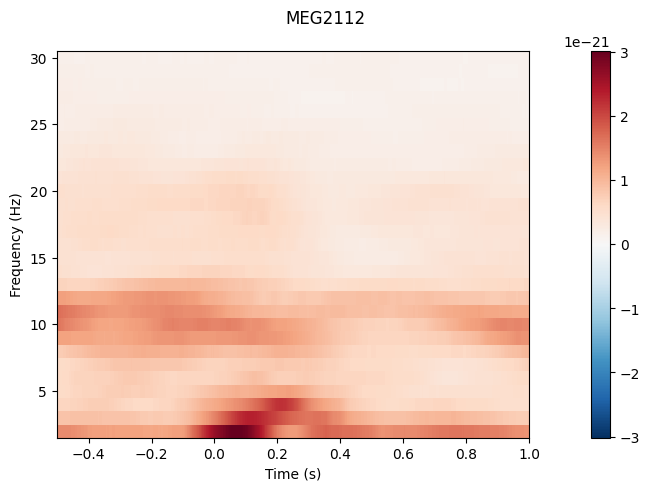

In [5]:
%matplotlib inline
tfr_slow_left.plot(
    picks=['MEG2112'], 
    tmin=-0.5, tmax=1.0, 
    title='MEG2112');    

注意在光栅开始之前的间隔中存在10-12 Hz的α波段活动。还注意在1-5 Hz时约0.2 s的功率增加，这可能反映了事件相关场的贡献。 
为了更好地观察这些效果，可以应用相对基线。我们选择了`mode="percent"`，因为这将对基线中的功率执行归一化：

$$ P_{relative}(t,f) = {Power(t,f) - Power_{baseline}(f) \over Power_{baseline}(f)} $$

由于滑动时间窗口ΔT=500 ms，我们选择了-500到-250 ms的基线。这确保了基线不会与t>0 ms的功率值重叠。

Applying baseline correction (mode: percent)


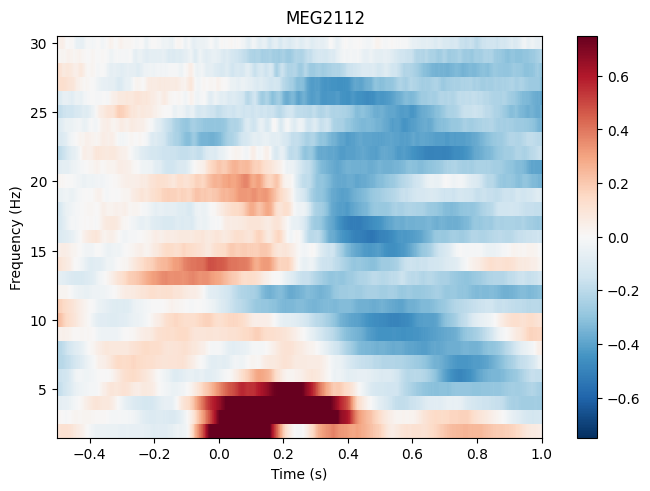

[<Figure size 640x480 with 2 Axes>]

In [ ]:
tfr_slow_left.plot(
    picks=['MEG2112'], 
    baseline=[-0.500,-0.250], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG2112',  
    vlim=[-0.75, 0.75] # 色彩映射表的上下限，通常是与数据单位相同的数值，原来的'vmin=-0.75, vmax=0.75'已被修改（https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne.time_frequency.AverageTFR.plot）
    )  

Applying baseline correction (mode: mean)


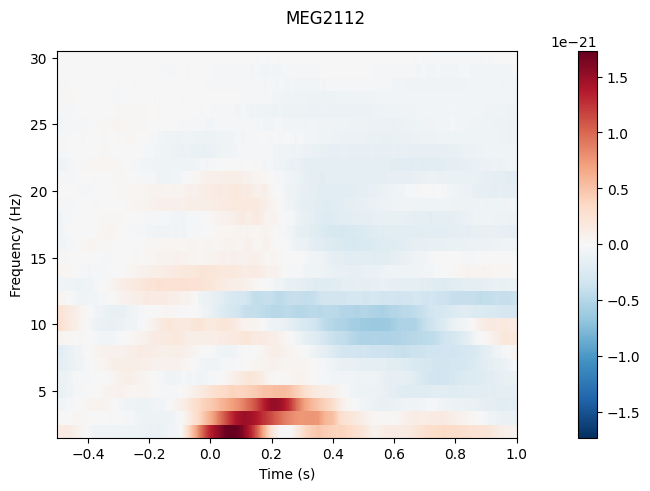

[<Figure size 640x480 with 2 Axes>]

In [ ]:
# 下面问题1的回答
tfr_slow_left.plot(
    picks=['MEG2112'], 
    baseline=[-0.500,-0.250], 
    mode="mean", # 使用绝对基线绘制
    tmin=-0.5, tmax=1,
    title='MEG2112',  
    # vlim=[-0.75, 0.75] # 此时限制这个上下限会导致图像无法全部显示
    )
# 使用绝对基线绘制的图像对比度不明显，相对基线的效果更好

基线校正模型说明：
mode‘mean’ | ‘ratio’ | ‘logratio’ | ‘percent’ | ‘zscore’ | ‘zlogratio’
Perform baseline correction by
- subtracting the mean of baseline values (‘mean’) (default)
> 减去基线值的平均值（'mean'）（默认）

- dividing by the mean of baseline values (‘ratio’)
> 除以基线值的平均值（“比率”）

- dividing by the mean of baseline values and taking the log (‘logratio’)
> 除以基线值的平均值并取对数（logratio）

- subtracting the mean of baseline values followed by dividing by the mean of baseline values (‘percent’)
> 减去基线值平均值，然后除以基线值平均值（“百分比”）

- subtracting the mean of baseline values and dividing by the standard deviation of baseline values (‘zscore’)
> 减去基线值的平均值并除以基线值的标准差（“zscore”）

- dividing by the mean of baseline values, taking the log, and dividing by the standard deviation of log baseline values (‘zlogratio’)
> 除以基线值的平均值，取对数，再除以对数基线值的标准差（“zlogratio”）

上图说明了响应视觉刺激的功率调制。注意10-12 Hz apha波段刺激开始后的典型功率下降，以及β波段约20 Hz时的一些功率下降。这些影响反映了视觉输入下持续振荡的减少。θ波段约5 Hz处的早期增加可能反映了事件相关场的频谱功率，即它不反映振荡活动*本身*的调制。

**问题1：** 使用绝对基线绘制结果。为什么在小组研究中通常使用相对基线？

要显示按地形排列的所有传感器的功率调制，请写入：

Applying baseline correction (mode: percent)


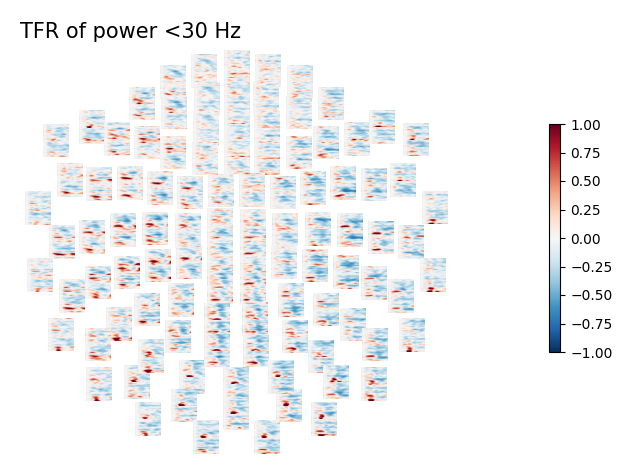

In [14]:
plt = tfr_slow_left.plot_topo(
    tmin=-0.5, tmax=1.0, 
    baseline=[-0.5,-0.3], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k',
    vmin=-1, vmax=1,
    title='TFR of power <30 Hz')

要在300到1000毫秒的时间间隔内显示阿尔法凹陷的地形图，请使用`plot_topomap`命令

Applying baseline correction (mode: percent)


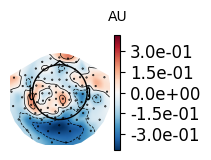

In [20]:
tfr_slow_right.plot_topomap(
    tmin=0.35, tmax=1, 
    fmin=9, fmax=11,
    baseline=[-0.5,-0.3], 
    mode="percent");

注意α抑制的轻微右后侧化。这很可能是由于注意力向右边转移。

**问题2**：对'attend left'试次重复分析。与'attend left'试次的结果有什么不同吗？

并没有看出有什么不同，是重复分析的方式不对吗


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:  1.4min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:  1.4min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:  1.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:  1.4min remaining:   27.7s


Applying baseline correction (mode: percent)


[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:  1.4min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.4min finished


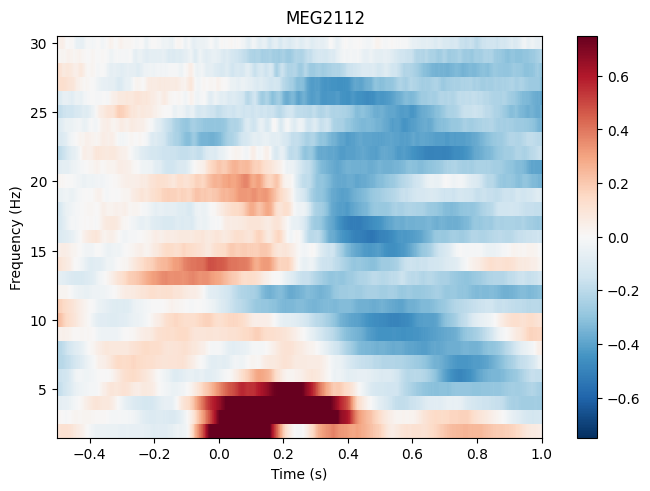

[<Figure size 640x480 with 2 Axes>]

In [21]:
freqs = np.arange(2, 31, 1) # 指定了要计算时频表示的频率范围
n_cycles = freqs / 2 # 每个频率对应的周期数，该参数决定了每个频率成分的时间分辨率。
time_bandwidth = 2.0 # 时间带宽积，这里设置为 2.0。它控制了多锥方法中使用的锥形窗数量，影响时频分辨率的权衡。

tfr_slow_left_repeat =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, # 指示使用快速傅里叶变换（FFT）来计算时频表示，这通常比直接时域卷积更快。
    return_itc=False, # 控制是否返回事件间相干性（ITC）。设置为 False 表示只返回功率谱，不返回 ITC
    average=True, # 表示对所有时间段的数据进行平均，最终返回平均的时频表示结果
    decim=2, # 下采样因子，设置为 2 表示在时间维度上对结果进行下采样，每隔一个样本取一个，以减少数据量
    n_jobs = -1, # 指定并行计算使用的 CPU 核心数，-1 表示使用所有可用的 CPU 核心，以加速计算过程
    verbose=True)

tfr_slow_left_repeat.plot(
    picks=['MEG2112'], 
    baseline=[-0.500,-0.250], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG2112',  
    vlim=[-0.75, 0.75] 
    )  


**问题3：** 将时间窗口更改为0.25秒并绘制结果。在时间和频率平滑方面的主要效果是什么？ 

频率更平滑了，时间上稍微压缩了


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:  1.4min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:  1.4min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:  1.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:  1.4min remaining:   27.7s


Applying baseline correction (mode: percent)


[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:  1.4min remaining:    3.9s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.4min finished


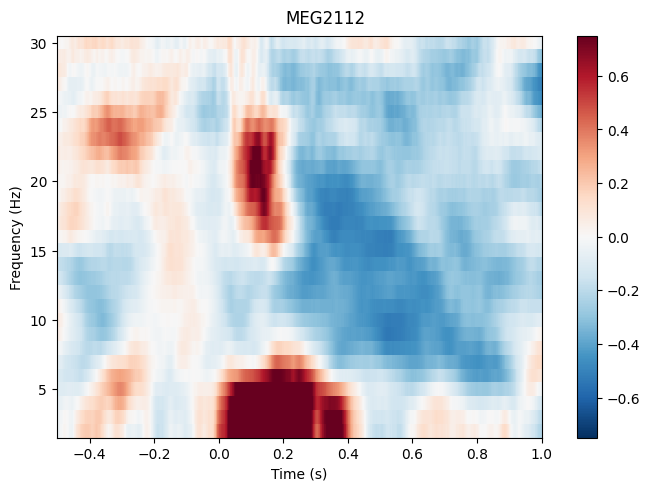

[<Figure size 640x480 with 2 Axes>]

In [ ]:
freqs = np.arange(2, 31, 1) # 指定了要计算时频表示的频率范围
n_cycles = freqs / 4 # 修改使时间窗口为0.25s
time_bandwidth = 2.0 # 时间带宽积，这里设置为 2.0。它控制了多锥方法中使用的锥形窗数量，影响时频分辨率的权衡。

tfr_slow_left_repeat =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, # 指示使用快速傅里叶变换（FFT）来计算时频表示，这通常比直接时域卷积更快。
    return_itc=False, # 控制是否返回事件间相干性（ITC）。设置为 False 表示只返回功率谱，不返回 ITC
    average=True, # 表示对所有时间段的数据进行平均，最终返回平均的时频表示结果
    decim=2, # 下采样因子，设置为 2 表示在时间维度上对结果进行下采样，每隔一个样本取一个，以减少数据量
    n_jobs = -1, # 指定并行计算使用的 CPU 核心数，-1 表示使用所有可用的 CPU 核心，以加速计算过程
    verbose=True)

tfr_slow_left_repeat.plot(
    picks=['MEG2112'], 
    baseline=[-0.250,0], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG2112',  
    vlim=[-0.75, 0.75] 
    )  

**问题4：** 将时间窗口更改为1.00秒并绘制结果。在时间和频率平滑方面的主要效果是什么？

在时间上更平滑了，频率上被稍微压缩了 

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
/home/ubuntu/miniconda3/envs/torch/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:    1.6s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:    1.9s remaining:    3.4s
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:    2.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:    2.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:    2.8s remaining:    0.1s


Applying baseline correction (mode: percent)


[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:    5.2s finished


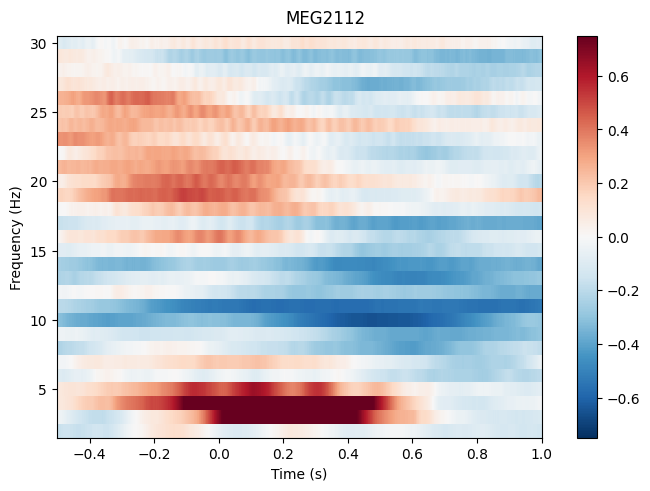

[<Figure size 640x480 with 2 Axes>]

In [ ]:
freqs = np.arange(2, 31, 1) # 指定了要计算时频表示的频率范围
n_cycles = freqs # 修改使时间窗口为1.00s
time_bandwidth = 2.0 # 时间带宽积，这里设置为 2.0。它控制了多锥方法中使用的锥形窗数量，影响时频分辨率的权衡。

tfr_slow_left_repeat =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'grad',
    use_fft=True, # 指示使用快速傅里叶变换（FFT）来计算时频表示，这通常比直接时域卷积更快。
    return_itc=False, # 控制是否返回事件间相干性（ITC）。设置为 False 表示只返回功率谱，不返回 ITC
    average=True, # 表示对所有时间段的数据进行平均，最终返回平均的时频表示结果
    decim=2, # 下采样因子，设置为 2 表示在时间维度上对结果进行下采样，每隔一个样本取一个，以减少数据量
    n_jobs = -1, # 指定并行计算使用的 CPU 核心数，-1 表示使用所有可用的 CPU 核心，以加速计算过程
    verbose=True)

tfr_slow_left_repeat.plot(
    picks=['MEG2112'], 
    baseline=[-1.00,-0.50], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG2112',  
    vlim=[-0.75, 0.75] 
    )  

## Comparing attend right versus attend left

已知线索刺激区间中的α活动受到空间注意力的高度调节。具体而言，许多研究表明，后α功率在对侧半球降低，而在同侧半球相对增加。为了识别这种效应，我们将说明线索刺激间隔（-0.5到0秒）中的α调制。这将通过计算功率侧化指数来实现：

$$ power \: lateralization \: index = {{power_{att,right} - power_{att,left}} \over {power_{att,right} + power_{att,left}}} $$

请注意，此度量是在不执行基线校正的情况下计算的。 



In [24]:
tfr_slow_diff = tfr_slow_left.copy()
tfr_slow_diff.data = (tfr_slow_right.data - tfr_slow_left.data)/(tfr_slow_right.data + tfr_slow_left.data)

To show the *power lateralization index* for all sensors write: 

No baseline correction applied


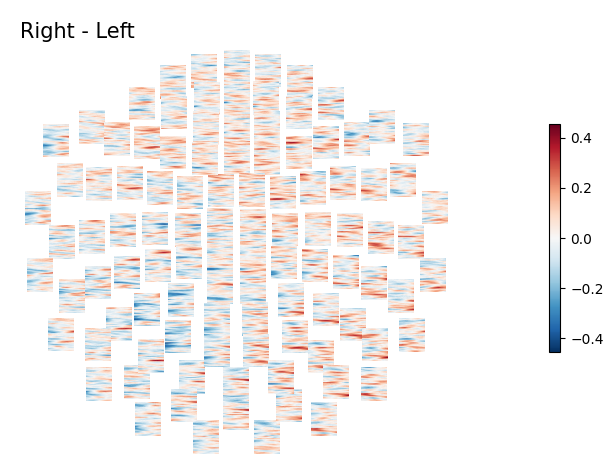

In [25]:
tfr_slow_diff.plot_topo(
    tmin=-0.5, tmax=0.0, 
    fig_facecolor='w',
    font_color='k',
    title='Right - Left');

为了说明10-12 Hz alpha频段的偏侧化指数，请使用`plot_topomap`函数：

No baseline correction applied


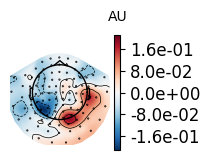

In [26]:
tfr_slow_diff.plot_topomap(tmin=-0.5, tmax=0, fmin=10, fmax=12);

## 更高频率（>30赫兹）的时频分析

要研究快速频率下的频谱调制，需要更多的频谱平滑。这可以通过设置来实现：

* *freqs*：定义执行分析的频率范围。我们将以2 Hz的步长考虑30到100 Hz。
* *n_cycles*：我们将周期数设为freqs/4。这导致时间窗口dT=250 ms，与频率无关。相对较短的时间窗口确保了良好的时间分辨率。
* *time_bandwidth*：将time_bandwith设置为4秒。这将导致N=3个锥度。当N<2* dT* dF时，得到的光谱平滑至少为6 Hz（N<2 * dT*dF => 3<2 * 0.25 * dF => dF>6）。相对较大的光谱平滑源于经验观察，即视觉伽马在一定程度上是宽带的。

有关多锥度方法的详细信息，请参见Percival和Walden（1993）。 

将这些设置应用于左右注意力条件（注意，此步骤可能非常耗时）：

In [6]:
freqs = np.arange(30, 101, 2)
n_cycles = freqs / 4 
time_bandwidth = 4.0

tfr_fast_left =  mne.time_frequency.tfr_multitaper(
    epochs['cue_left'], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth=time_bandwidth,
    picks='grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = -1,
    verbose=True)

tfr_fast_right = mne.time_frequency.tfr_multitaper(
    epochs['cue_right'],
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth=time_bandwidth,
    picks='grad',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=2,
    n_jobs = -1,
    verbose=True)

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:  1.2min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:  1.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:  1.3min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:  1.3min remaining:   25.4s
[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:  1.3min remaining:    3.6s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  1.3min finished


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 256 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of 204 | elapsed:    1.7s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  72 out of 204 | elapsed:    2.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 113 out of 204 | elapsed:    3.0s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done 154 out of 204 | elapsed:   21.6s remaining:    7.0s
[Parallel(n_jobs=-1)]: Done 195 out of 204 | elapsed:   24.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:   24.6s finished


现在使用-0.5到-0.125 ms基线绘制代表性后验传感器的功率TFR。我们选择这个基线间隔，因为时间窗口的长度是250 ms。 

Applying baseline correction (mode: percent)


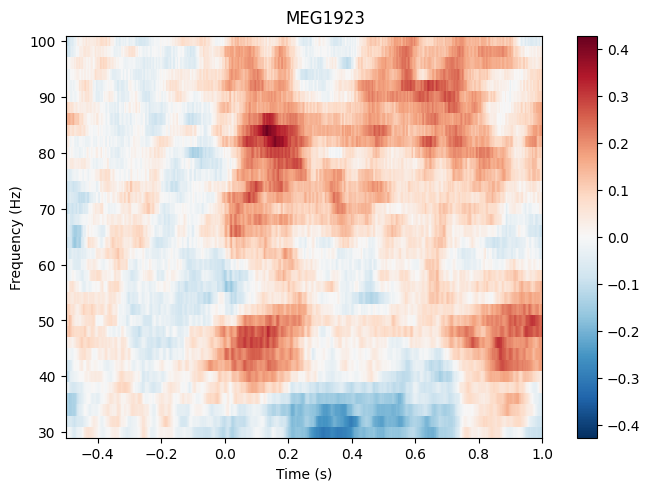

[<Figure size 640x480 with 2 Axes>]

In [7]:
tfr_fast_left.plot(
    picks=['MEG1923'], 
    baseline=[-0.5,-0.125], 
    mode="percent", 
    tmin=-0.5, tmax=1,
    title='MEG1923') 

注意80-90Hz伽马功率的增加响应于光栅的开始（t=0 s）。

要显示所有传感器的TFR，请写入：

Applying baseline correction (mode: percent)


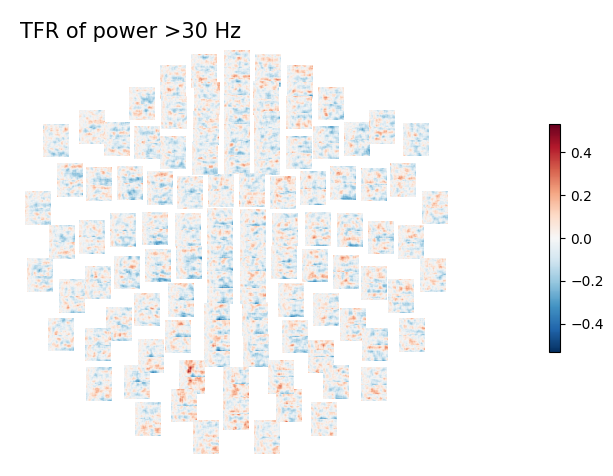

In [8]:
tfr_fast_left.plot_topo(
    tmin=-0.5, tmax=1.0, 
    baseline = [-0.5,-0.125], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k', 
    title='TFR of power >30 Hz');

对于响应光栅的伽马活动的地形表示，请写入： 

Applying baseline correction (mode: percent)


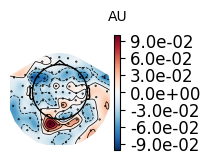

In [9]:
tfr_fast_left.plot_topomap(
    tmin=0.0, tmax=0.6, 
    fmin=60, fmax=90, 
    baseline = [-0.5,-0.125], 
    mode="percent", 
    vlim=(-0.1, 0.1));

这里欣赏伽马带活动的后验分布。 

接下来，计算*功率偏侧化指数*（使用与较低频率相同的方程）。 


In [10]:
tfr_fast_diff = tfr_fast_left.copy()
tfr_fast_diff.data = (tfr_fast_right.data - tfr_fast_left.data)/(tfr_fast_right.data + tfr_fast_left.data)

并显示所有传感器：

No baseline correction applied


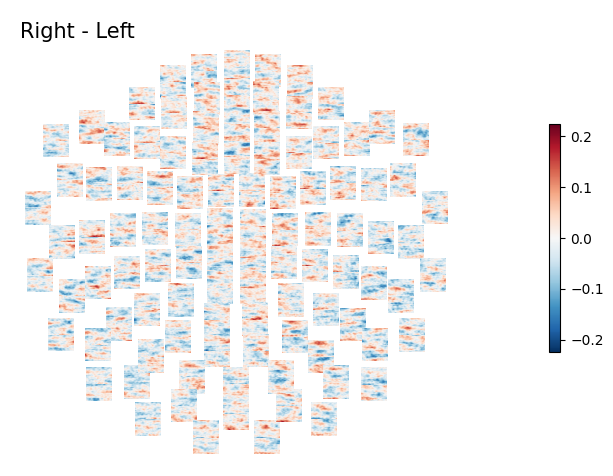

In [11]:
tfr_fast_diff.plot_topo(
    tmin=-0.5, tmax=0.0, 
    fig_facecolor='w',
    font_color='k', 
    title='Right - Left');

以及地形图： 

No baseline correction applied


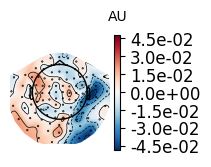

In [12]:
tfr_fast_diff.plot_topomap(
    tmin=0.0, tmax=0.6, 
    fmin=60, fmax=90);

**问题5：** 比较γ偏侧化和α偏侧化。解释α和γ带偏侧化与神经元处理和功能抑制的关系。

**问题6：** 将平滑更改为20Hz。这会导致多少个锥度？对时频表示有什么后果？

平滑更改为20Hz会导致10个锥度，当平滑参数调整为 20Hz 时，对时频表示可能产生以下影响：
- 时间分辨率和频率分辨率的变化
    - 平滑参数主要影响时频表示的分辨率。一般来说，较小的平滑参数会带来较高的时间分辨率，但频率分辨率会降低；而较大的平滑参数，如 20Hz，会使频率分辨率提高，时间分辨率降低。这意味着在时频图上，频率轴上的细节会更加清晰，能够更准确地分辨不同频率成分，但在时间轴上的变化会变得相对模糊，难以精确确定信号在短时间内的频率变化。
- 时频聚集性的改变
    - 平滑参数的增大有助于提高时频表示的聚集性。当平滑参数为 20Hz 时，时频分布会更加集中在信号的真实频率附近，减少了频谱的扩散和旁瓣效应。这使得时频图上的信号能量更加集中，更易于观察和分析信号的主要频率成分及其随时间的变化趋势。
- 噪声抑制效果增强
    - 较大的平滑参数具有一定的低通滤波作用，能够在一定程度上抑制高频噪声。将平滑参数调整为 20Hz 时，可以使时频表示中的噪声成分得到衰减，使信号的时频特征更加突出，提高了信号在噪声环境下的可辨识度。但同时也可能会损失一些高频信号的细节信息。
- 时频图的整体平滑性提高
    - 随着平滑参数的增加，时频图在时间和频率两个维度上都会变得更加平滑。20Hz 的平滑参数会使时频图中的波动和毛刺减少，图像更加光滑，视觉效果更好，便于对信号的整体时频特性进行分析和理解。但过度平滑可能会导致一些微弱的时频特征被掩盖。

## Preregistration and publications

It is essential to report all the parameters in the frequency analysis both when submitting a preregistration and a manuscript. Note that the analysis based on a standard spectral analysis and should be independent on the toolbox applied.

Example for text to be used for publications and preregistration:

"The time-frequency representations of power were calculated using a sliding time window approach applied to the single trials (Tallon-Baudry and Bertrand, 1999). For frequencies lower than 30 Hz we used a 500 ms time window. A single discrete prolate spheroidal taper was multiplied to each time window prior to calculating the discrete Fourier transform. This resulted in ±3 Hz spectral smoothing. The power was then estimated as the squared modulus of the Fourier transform. This was done for 1 to 30 Hz in steps of 1 Hz. For frequencies above 30 Hz, a multi-taper method approach (Percival and Walden, 1993) was used involving a sliding time window of 0.25 s. To ensure sufficient spectral smoothing to detect the gamma activity, a set of tapers derived from discrete prolate spheroidal (DPSS), or Slepian sequences, were multiplied to the time-windowed data. We used 3 tapers resulting in a spectral smoothing of ~±8 Hz. Following a discrete Fourier transform the power estimate for the respective tapers were averaged. This was done for 30 to 100 Hz in steps of 2 Hz. The power estimates per trial were subsequently averaged. The relative change in power was then considered with respect to a baseline (-0.5 – -0.25 ms for f < 30 Hz and -0.5 – -0.125 ms for f > 30 Hz). "

## References
* Tallon-Baudry and Bertrand (1999) Oscillatory gamma activity in humans and its role in object representation. Trends Cogn Sci. 3(4):151-162
* Mitra and Pesaran (1999) Analysis of dynamic brain imaging data. Biophys J. 76(2):691-708
* Percival and Walden (1993) Spectral analysis for physical applications: multitaper and conventional univariate techniques. Cambridge, UK
